In [13]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [14]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [15]:
# Import Dataset
#df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
#print(df.target_names.unique())
#df.head()

df = pd.read_csv('./generated/seqgan.csv', quoting = 3).dropna().reset_index(drop=True)

In [16]:
df.columns

Index(['NARRATIVE'], dtype='object')

In [17]:
word_replace_dic = {
        ' vic ':' victim ',
        ' vict ':' victim ',
        ' sus ': ' suspect ',
        ' s1 ': ' suspect ',
        ' v1 ': ' victim ',
        ' loc ': ' location ',
        ' veh ':' vehicle ',
        ' prop ': ' property ',
        ' unk ': ' unknown ',
        ' v ' : ' victim ',
        ' s ': ' suspect ',
        ' ss ': ' suspect ',
        ' susp ': ' suspect ',
        ' remvd ': ' removed ',
        ' victs ': ' victims ',
        ' susps ': ' suspects ',
        ' stillinside ': ' still inside ',
        ' donttell ': ' dont tell ',
        ' veerbal ': ' verbal ',
        ' thransaction ': ' transaction ',
        ' usedcredit ': ' used credit ',
        ' beerbottle ' : ' beer bottle ',
        ' neg ': ' negative ',
        ' cointinuously ': ' continuously ',
        ' lemmon ': ' lemon ',
        ' att ': ' attack '
            }
df['content'] = " " + df['NARRATIVE'].str.lower()+ " "
#df['content'] = df.cleaned.replace(word_replace_dic)#, regex=True)

In [18]:

for key, value in word_replace_dic.items():
    df['content'] = df['content'].str.replace(key, value, 10)


In [19]:
df['NARRATIVE'][2673]

's removed construction ; 2 bicycles apt without paying for prop s fled loc in unk dir v wasnt able returned v1 prop causing v bleeding s then fled no susps seen '

In [20]:
df['content'][2673]

' suspect removed construction ; 2 bicycles apt without paying for property suspect fled location in unknown dir victim wasnt able returned victim property causing victim bleeding suspect then fled no suspects seen  '

In [21]:

for key, value in word_replace_dic.items():
    df['content'] = df['content'].str.replace(key, value, 10)

In [22]:
df[df['content'].str.contains(" vict ")]['content']
#df.columns #= ['DR', 'CRIMETYPE', 'BEGDATE', 'content', 'X', 'Y', 'NARRATIVE_FLAG']

Series([], Name: content, dtype: object)

In [23]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

[' suspect entered res thru unlocked door removed victim rings rack when victim checked but fled location in unknown dir ']


### Tokenize words and Clean-up text

In [24]:

#I have set deacc=True to remove the punctuations.

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['suspect', 'entered', 'res', 'thru', 'unlocked', 'door', 'removed', 'victim', 'rings', 'rack', 'when', 'victim', 'checked', 'but', 'fled', 'location', 'in', 'unknown', 'dir']]


In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['suspect', 'entered', 'res', 'thru', 'unlocked', 'door', 'removed', 'victim', 'rings', 'rack', 'when', 'victim', 'checked', 'but', 'fled', 'location', 'in', 'unknown', 'dir']


In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['enter', 're', 'unlocked', 'door', 'remove', 'victim', 'ring', 'rack', 'victim', 'check', 'flee', 'location', 'unknown', 'dir']]


### Create the Dictionary and Corpus needed for Topic Modeling

In [28]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2)]]


In [29]:
id2word[0]

'check'

In [30]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('check', 1),
  ('dir', 1),
  ('door', 1),
  ('enter', 1),
  ('flee', 1),
  ('location', 1),
  ('rack', 1),
  ('re', 1),
  ('remove', 1),
  ('ring', 1),
  ('unknown', 1),
  ('unlocked', 1),
  ('victim', 2)]]

In [31]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.411*"victim" + 0.247*"suspect" + 0.014*"verbal" + 0.013*"strike" + '
  '0.011*"cause" + 0.011*"time" + 0.010*"grab" + 0.010*"throw" + '
  '0.010*"dispute" + 0.010*"attack"'),
 (1,
  '0.059*"threaten" + 0.049*"see" + 0.047*"entered" + 0.045*"park" + '
  '0.045*"attempt" + 0.042*"stop" + 0.035*"area" + 0.032*"pull" + '
  '0.026*"permission" + 0.023*"fall"'),
 (2,
  '0.225*"entry" + 0.210*"gain" + 0.066*"garage" + 0.055*"arrest" + '
  '0.053*"confront" + 0.044*"unkn" + 0.039*"truck" + 0.030*"broke" + '
  '0.027*"roof" + 0.018*"restroom"'),
 (3,
  '0.164*"unknown" + 0.158*"suspect" + 0.082*"property" + 0.081*"flee" + '
  '0.077*"vehicle" + 0.055*"location" + 0.045*"remove" + 0.036*"take" + '
  '0.033*"enter" + 0.029*"victim"'),
 (4,
  '0.342*"leave" + 0.106*"back" + 0.079*"kick" + 0.048*"come" + 0.031*"street" '
  '+ 0.028*"work" + 0.027*"look" + 0.024*"employee" + 0.024*"floor" + '
  '0.022*"stand"'),
 (5,
  '0.114*"order" + 0.077*"stab" + 0.051*"bit" + 0.050*"trunk" + '
  '0.04

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.019500120971387

Coherence Score:  0.46198560776478637


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.391298 -0.066739       1        1  37.485172
0     -0.377730 -0.082138       2        1  29.432968
10     0.013215  0.166091       3        1   8.382991
11    -0.028428  0.403344       4        1   8.003082
1      0.044833  0.030184       5        1   4.559771
7      0.090345 -0.053953       6        1   2.508691
6      0.081346 -0.041275       7        1   2.479246
4      0.098075 -0.060887       8        1   2.000363
2      0.102154 -0.064885       9        1   1.697962
9      0.106880 -0.069757      10        1   1.613843
8      0.116021 -0.076899      11        1   1.506331
5      0.144588 -0.083085      12        1   0.329571, topic_info=     Category          Freq          Term         Total  loglift  logprob
12    Default  16384.000000        victim  16384.000000  30.0000  30.0000
20    Default  16394.000000       suspect  16394.000000  29.0000  29.0000
10    Default   7631.000000       unknown   7631.000000  28.0000  28.0000
46    Default   3809.000000      property   3809.000000  27.0000  27.0000
4     Default   3753.000000          flee   3753.000000  26.0000  26.0000
21    Default   3566.000000       vehicle   3566.000000  25.0000  25.0000
22    Default   1329.000000        window   1329.000000  24.0000  24.0000
94    Default    852.000000         leave    852.000000  23.0000  23.0000
2     Default   1278.000000          door   1278.000000  22.0000  22.0000
153   Default   1065.000000          open   1065.000000  21.0000  21.0000
5     Default   2540.000000      location   2540.000000  20.0000  20.0000
8     Default   2079.000000        remove   2079.000000  19.0000  19.0000
49    Default    476.000000         entry    476.000000  18.0000  18.0000
61    Default    444.000000          gain    444.000000  17.0000  17.0000
232   Default    482.000000         store    482.000000  16.0000  16.0000
58    Default    678.000000          rear    678.000000  15.0000  15.0000
98    Default    665.000000         smash    665.000000  14.0000  14.0000
151   Default    401.000000          item    401.000000  13.0000  13.0000
33    Default   1668.000000          take   1668.000000  12.0000  12.0000
148   Default    607.000000          side    607.000000  11.0000  11.0000
3     Default   1540.000000         enter   1540.000000  10.0000  10.0000
477   Default    342.000000          exit    342.000000   9.0000   9.0000
24    Default    565.000000         front    565.000000   8.0000   8.0000
13    Default    345.000000      approach    345.000000   7.0000   7.0000
358   Default    509.000000         punch    509.000000   6.0000   6.0000
60    Default   1275.000000           use   1275.000000   5.0000   5.0000
31    Default    484.000000         phone    484.000000   4.0000   4.0000
59    Default    470.000000         state    470.000000   3.0000   3.0000
79    Default    273.000000          walk    273.000000   2.0000   2.0000
81    Default    465.000000          face    465.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
184   Topic12     46.604168         order     47.530712   5.6954  -2.1734
627   Topic12     31.472446          stab     32.398991   5.6861  -2.5660
625   Topic12     20.803362           bit     21.729908   5.6716  -2.9799
1229  Topic12     20.342213         trunk     21.268757   5.6706  -3.0024
182   Topic12     19.862947       custody     20.789495   5.6695  -3.0262
1145  Topic12     15.754344      trespass     16.680895   5.6580  -3.2579
814   Topic12     13.423531        letter     14.350088   5.6484  -3.4181
977   Topic12      7.062711         court      7.989261   5.5919  -4.0602
2239  Topic12      2.164436      firework      3.090999   5.3588  -5.2429
742   Topic12      0.058519          comp      1.011613   2.8652  -8.8535
2545  Topic12      0.055701      sandwich      0.989248   2.8382  -8.9028
4647  Topic12      

In [35]:

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

#mallet_path = 'F:\\mallet-2.0.8\\bin\\mallet'
mallet_path = "F:\\mallet-2.0.8\\bin\\mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

In [36]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=12, formatted=False))

[(0,
  [('suspect', 0.3775304716481187),
   ('victim', 0.36014838367779545),
   ('attack', 0.02851086380498145),
   ('approach', 0.022363540010598836),
   ('pull', 0.016216216216216217),
   ('cellphone', 0.01091679915209327),
   ('point', 0.009009009009009009),
   ('spray', 0.008797032326444092),
   ('floor', 0.007737148913619502),
   ('stab', 0.007207207207207207)]),
 (1,
  [('victim', 0.1870027895443744),
   ('suspect', 0.07686744498398596),
   ('state', 0.052794710197334435),
   ('phone', 0.04659572269862589),
   ('call', 0.032648000826531666),
   ('money', 0.029651823535489202),
   ('threaten', 0.022729620828597995),
   ('kill', 0.021489823328856288),
   ('fear', 0.01994007645417915),
   ('cell', 0.01901022832937287)]),
 (2,
  [('flee', 0.22263184843830006),
   ('location', 0.1956989247311828),
   ('suspect', 0.183205325140809),
   ('property', 0.11213517665130568),
   ('unknown', 0.07270865335381464),
   ('foot', 0.026011264720942142),
   ('direction', 0.022939068100358423),
   ('

In [37]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
# Compute Perplexity
#print('\nPerplexity: ', ldamallet.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Coherence Score:  0.4227286959645063


In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

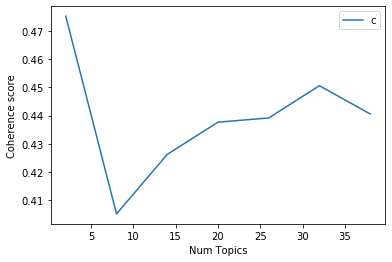

In [40]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4753
Num Topics = 8  has Coherence Value of 0.405
Num Topics = 14  has Coherence Value of 0.4262
Num Topics = 20  has Coherence Value of 0.4377
Num Topics = 26  has Coherence Value of 0.4392
Num Topics = 32  has Coherence Value of 0.4506
Num Topics = 38  has Coherence Value of 0.4406


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 12 topics itself.


In [42]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.268*"location" + 0.227*"flee" + 0.212*"suspect" + 0.065*"property" + '
  '0.064*"unknown" + 0.031*"foot" + 0.018*"key" + 0.013*"wall" + '
  '0.005*"removed" + 0.004*"prop"'),
 (1,
  '0.324*"victim" + 0.241*"suspect" + 0.042*"approach" + 0.027*"walk" + '
  '0.023*"attack" + 0.023*"stop" + 0.023*"knife" + 0.020*"scratch" + '
  '0.015*"pull" + 0.014*"begin"'),
 (2,
  '0.268*"suspect" + 0.259*"victim" + 0.054*"verbal" + 0.038*"dispute" + '
  '0.034*"grab" + 0.034*"argument" + 0.019*"engage" + 0.018*"involve" + '
  '0.016*"hand" + 0.016*"arm"'),
 (3,
  '0.432*"unknown" + 0.083*"flee" + 0.066*"entry" + 0.059*"gain" + 0.057*"dir" '
  '+ 0.050*"tool" + 0.028*"remove" + 0.023*"force" + 0.016*"object" + '
  '0.016*"ent"'),
 (4,
  '0.376*"suspect" + 0.326*"victim" + 0.021*"drive" + 0.017*"wit" + '
  '0.014*"reach" + 0.013*"cellphone" + 0.012*"security" + 0.009*"resd" + '
  '0.007*"chase" + 0.007*"detain"'),
 (5,
  '0.146*"window" + 0.145*"door" + 0.102*"open" + 0.076*"rear" + 0.072*"sma

In [43]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.269719 -0.118522       1        1  8.498888
8      0.338445  0.189389       2        1  8.379845
10    -0.196595  0.013749       3        1  8.366827
6      0.368708  0.112574       4        1  8.352721
3     -0.066003 -0.057784       5        1  8.337303
2      0.164926  0.187268       6        1  8.327889
4     -0.244018  0.036515       7        1  8.323146
9     -0.228855  0.018341       8        1  8.319637
0     -0.251676  0.032994       9        1  8.313582
1     -0.173707 -0.039926      10        1  8.299693
11     0.231713 -0.384407      11        1  8.254278
5     -0.212657  0.009807      12        1  8.226192, topic_info=     Category          Freq        Term         Total  loglift  logprob
10    Default   7713.000000     unknown   7713.000000  30.0000  30.0000
12    Default  16778.000000      victim  16778.000000  29.0000  29.0000
20    Default  16645.000000     suspect  16645.000000  28.0000  28.0000
21    Default   3889.000000     vehicle   3889.000000  27.0000  27.0000
46    Default   3679.000000    property   3679.000000  26.0000  26.0000
4     Default   3827.000000        flee   3827.000000  25.0000  25.0000
5     Default   2543.000000    location   2543.000000  24.0000  24.0000
8     Default   2100.000000      remove   2100.000000  23.0000  23.0000
22    Default   1319.000000      window   1319.000000  22.0000  22.0000
2     Default   1316.000000        door   1316.000000  21.0000  21.0000
3     Default   1559.000000       enter   1559.000000  20.0000  20.0000
153   Default    923.000000        open    923.000000  19.0000  19.0000
58    Default    689.000000        rear    689.000000  18.0000  18.0000
98    Default    655.000000       smash    655.000000  17.0000  17.0000
148   Default    635.000000        side    635.000000  16.0000  16.0000
1     Default    611.000000         dir    611.000000  15.0000  15.0000
24    Default    584.000000       front    584.000000  14.0000  14.0000
94    Default    835.000000       leave    835.000000  13.0000  13.0000
61    Default    549.000000        gain    549.000000  12.0000  12.0000
59    Default    544.000000       state    544.000000  11.0000  11.0000
358   Default    538.000000       punch    538.000000  10.0000  10.0000
81    Default    525.000000        face    525.000000   9.0000   9.0000
51    Default    491.000000        lock    491.000000   8.0000   8.0000
31    Default    480.000000       phone    480.000000   7.0000   7.0000
151   Default    478.000000        item    478.000000   6.0000   6.0000
252   Default    475.000000      strike    475.000000   5.0000   5.0000
206   Default    470.000000      verbal    470.000000   4.0000   4.0000
232   Default    467.000000       store    467.000000   3.0000   3.0000
49    Default    615.000000       entry    615.000000   2.0000   2.0000
54    Default    446.000000        tool    446.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
356   Topic12     66.907083    personal     66.907083   2.4978  -5.0290
227   Topic12     64.713409        bank     64.713409   2.4978  -5.0624
540   Topic12     58.132384     account     58.132384   2.4978  -5.1696
1062  Topic12     53.745034       forge     53.745034   2.4978  -5.2481
764   Topic12     52.648197         sit     52.648197   2.4978  -5.2687
587   Topic12     48.260847        rent     48.260847   2.4978  -5.3557
57    Topic12     46.067172    identity     46.067172   2.4978  -5.4022
1633  Topic12     46.067172      number     46.067172   2.4978  -5.4022
505   Topic12     44.970335    possibly     44.970335   2.4978  -5.4263
1144  Topic12     44.970335        case     44.970335   2.4978  -5.4263
1109  Topic12     41.679822        live     41.679822   2.4978  -5.5023
329   Topic12     40.582985      credit     40.582985   2.4978  -5.5290
404   Topic12     38.389310      unable     38.

In [44]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Perplexity:  nan


C:\Users\Samira\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1108: RuntimeWarning: invalid value encountered in multiply
  score += np.sum((self.eta - _lambda) * Elogbeta)
C:\Users\Samira\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1109: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(_lambda) - gammaln(self.eta))


## Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [45]:
def format_two_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                topic_num0 = topic_num
                prop_topic0 = prop_topic
                wp0 = ldamodel.show_topic(topic_num0)
                topic_keywords0 = ", ".join([word for word, prop in wp0])
            elif j == 1:  # => dominant topic
                topic_num1 = topic_num
                prop_topic1 = prop_topic
                wp1 = ldamodel.show_topic(topic_num1)
                topic_keywords1 = ", ".join([word for word, prop in wp1])
            else:
                break
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num0), round(prop_topic0,4), topic_keywords0,int(topic_num1), round(prop_topic1,4), topic_keywords1]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic0', 'Perc_Contribution0', 'Topic_Keywords0', 'Dominant_Topic1', 'Perc_Contribution1', 'Topic_Keywords1']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#df_two_topic_sents_keywords = format_two_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_two_topic_sents_keywords = format_two_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_two_dominant_topic = df_two_topic_sents_keywords.reset_index()
df_two_dominant_topic.columns = ['Document_No', 'Dominant_Topic0', 'Topic_Perc_Contrib0', 'Keywords0', 'Dominant_Topic1', 'Topic_Perc_Contrib1', 'Keywords1', 'Text']

# Show
df_two_dominant_topic.head(10)

,Document_No,Dominant_Topic0,Topic_Perc_Contrib0,Keywords0,Dominant_Topic1,Topic_Perc_Contrib1,Keywords1,Text
0,0,6.0,0.1190,"property, remove, unknown, enter, flee, resid,...",11.0,0.0979,"gain, location, item, store, enter, entry, bus...",suspect entered res thru unlocked door remove...
1,1,7.0,0.1317,"window, door, open, unknown, rear, smash, side...",3.0,0.0977,"vehicle, victim, lock, leave, suspect, return,...",unknown suspect approached victim vehicle bro...
2,2,7.0,0.1082,"window, door, open, unknown, rear, smash, side...",11.0,0.0984,"gain, location, item, store, enter, entry, bus...",suspects spray painted graffiti on victims ba...
3,3,1.0,0.1121,"victim, suspect, state, phone, call, money, th...",9.0,0.1121,"victim, suspect, punch, face, push, time, appr...",suspect approached victim and demanded her mo...
4,4,10.0,0.1293,"victim, suspect, strike, verbal, hit, throw, g...",0.0,0.1137,"suspect, victim, attack, approach, pull, cellp...",unknown suspect pointed handgun and pushed vi...
5,5,1.0,0.1199,"victim, suspect, state, phone, call, money, th...",3.0,0.0906,"vehicle, victim, lock, leave, suspect, return,...",22350 poe victim called victim vehicle bypa a...
6,6,6.0,0.1158,"property, remove, unknown, enter, flee, resid,...",2.0,0.0951,"flee, location, suspect, property, unknown, fo...",unknown suspect ent victim garage rmvd victim...
7,7,8.0,0.1153,"unknown, flee, vehicle, dir, tool, damage, cut...",3.0,0.1103,"vehicle, victim, lock, leave, suspect, return,...",unknown suspect made entry into the victim lo...
8,8,8.0,0.1415,"unknown, flee, vehicle, dir, tool, damage, cut...",1.0,0.0894,"victim, suspect, state, phone, call, money, th...",victim stated that using their identity that ...
9,9,8.0,0.1291,"unknown, flee, vehicle, dir, tool, damage, cut...",3.0,0.1085,"vehicle, victim, lock, leave, suspect, return,...",unknown suspect broke victim vehicle hood of ...


In [46]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.1190,"property, remove, unknown, enter, flee, resid,...",suspect entered res thru unlocked door remove...
1,1,7.0,0.1317,"window, door, open, unknown, rear, smash, side...",unknown suspect approached victim vehicle bro...
2,2,7.0,0.1082,"window, door, open, unknown, rear, smash, side...",suspects spray painted graffiti on victims ba...
3,3,1.0,0.1121,"victim, suspect, state, phone, call, money, th...",suspect approached victim and demanded her mo...
4,4,10.0,0.1293,"victim, suspect, strike, verbal, hit, throw, g...",unknown suspect pointed handgun and pushed vi...
5,5,1.0,0.1199,"victim, suspect, state, phone, call, money, th...",22350 poe victim called victim vehicle bypa a...
6,6,6.0,0.1158,"property, remove, unknown, enter, flee, resid,...",unknown suspect ent victim garage rmvd victim...
7,7,8.0,0.1153,"unknown, flee, vehicle, dir, tool, damage, cut...",unknown suspect made entry into the victim lo...
8,8,8.0,0.1415,"unknown, flee, vehicle, dir, tool, damage, cut...",victim stated that using their identity that ...
9,9,8.0,0.1291,"unknown, flee, vehicle, dir, tool, damage, cut...",unknown suspect broke victim vehicle hood of ...


## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. 

In [47]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1633,"suspect, victim, attack, approach, pull, cellp...",suspect fired multiple victim across street a...
1,1.0,0.2328,"victim, suspect, state, phone, call, money, th...",dv called pd suspect stated im going to call ...
2,2.0,0.1615,"flee, location, suspect, property, unknown, fo...",unknown suspects entered front yard without l...
3,3.0,0.2525,"vehicle, victim, lock, leave, suspect, return,...",parked and secured vehicle in vehicle passeng...
4,4.0,0.1855,"suspect, victim, hand, knife, stop, demand, dr...",victim was driving suspect demanded self as h...


In [48]:
sent_two_topics_sorteddf_mallet = pd.DataFrame()

sent_two_topics_outdf_grpd = df_two_topic_sents_keywords.groupby('Dominant_Topic0')

for i, grp in sent_two_topics_outdf_grpd:
    sent_two_topics_sorteddf_mallet = pd.concat([sent_two_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution0'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_two_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
#sent_two_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_two_topics_sorteddf_mallet.head()

,Dominant_Topic0,Perc_Contribution0,Topic_Keywords0,Dominant_Topic1,Perc_Contribution1,Topic_Keywords1,0
0,0.0,0.1633,"suspect, victim, attack, approach, pull, cellp...",4.0,0.1086,"suspect, victim, hand, knife, stop, demand, dr...",suspect fired multiple victim across street a...
1,1.0,0.2328,"victim, suspect, state, phone, call, money, th...",5.0,0.0923,"suspect, victim, make, check, walk, permission...",dv called pd suspect stated im going to call ...
2,2.0,0.1615,"flee, location, suspect, property, unknown, fo...",6.0,0.1085,"property, remove, unknown, enter, flee, resid,...",unknown suspects entered front yard without l...
3,3.0,0.2525,"vehicle, victim, lock, leave, suspect, return,...",0.0,0.0825,"suspect, victim, attack, approach, pull, cellp...",parked and secured vehicle in vehicle passeng...
4,4.0,0.1855,"suspect, victim, hand, knife, stop, demand, dr...",1.0,0.0966,"victim, suspect, state, phone, call, money, th...",victim was driving suspect demanded self as h...


## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [49]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,"property, remove, unknown, enter, flee, resid,...",364.0,0.0365
1,7.0,"window, door, open, unknown, rear, smash, side...",1062.0,0.1064
2,7.0,"window, door, open, unknown, rear, smash, side...",605.0,0.0606
3,1.0,"victim, suspect, state, phone, call, money, th...",870.0,0.0871
4,10.0,"victim, suspect, strike, verbal, hit, throw, g...",489.0,0.0490
5,1.0,"victim, suspect, state, phone, call, money, th...",700.0,0.0701
6,6.0,"property, remove, unknown, enter, flee, resid,...",1066.0,0.1068
7,8.0,"unknown, flee, vehicle, dir, tool, damage, cut...",1256.0,0.1258
8,8.0,"unknown, flee, vehicle, dir, tool, damage, cut...",847.0,0.0848
9,8.0,"unknown, flee, vehicle, dir, tool, damage, cut...",757.0,0.0758


In [50]:
# Show
df_dominant_topics.head(12)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,"property, remove, unknown, enter, flee, resid,...",364.0,0.0365
1,7.0,"window, door, open, unknown, rear, smash, side...",1062.0,0.1064
2,7.0,"window, door, open, unknown, rear, smash, side...",605.0,0.0606
3,1.0,"victim, suspect, state, phone, call, money, th...",870.0,0.0871
4,10.0,"victim, suspect, strike, verbal, hit, throw, g...",489.0,0.0490
5,1.0,"victim, suspect, state, phone, call, money, th...",700.0,0.0701
6,6.0,"property, remove, unknown, enter, flee, resid,...",1066.0,0.1068
7,8.0,"unknown, flee, vehicle, dir, tool, damage, cut...",1256.0,0.1258
8,8.0,"unknown, flee, vehicle, dir, tool, damage, cut...",847.0,0.0848
9,8.0,"unknown, flee, vehicle, dir, tool, damage, cut...",757.0,0.0758


In [51]:
df_dominant_topic.to_csv('df_dominant_topics_seqgan.csv')